In [2]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

In [3]:
from PIL import Image
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pandas as pd

First, we must understand that the SET image ranges are different to a conventional mammography, negative numbers are spected (unless shifted) and the backgorund is not 0. For our task the important thing is to be sure that the pixel distributioninside of the mask does not have any irregularities.

In [4]:
def stats_image(im_path:Path, show_histogram:bool=False):
    """show some information about the image in the given path

    Args:
        im_path (Path): _description_
        show_histogram (bool, optional): _description_. Defaults to False.
    """
    # if im_path is path
    if isinstance(im_path, Path):
      # open image with simpleitk
      im_sitk = sitk.ReadImage(str(im_path))
    else:
      im_sitk = im_path
    # get dtype
    print(f'dtype: {im_sitk.GetPixelIDTypeAsString()}')
    print(f'Get size: {im_sitk.GetSize()}')
    print(f'Get direction: {im_sitk.GetDirection()}')
    print(f'Get spacing: {im_sitk.GetSpacing()}')
    print(f'The origin: {im_sitk.GetOrigin()}')
    # min and max
    print(f'Min: {sitk.GetArrayFromImage(im_sitk).min()}')
    print(f'Max: {sitk.GetArrayFromImage(im_sitk).max()}\n')
    
    if show_histogram:
        im_array = sitk.GetArrayFromImage(im_sitk)
        # min value 32000
        plt.hist(im_array.flatten(), bins=500, range=(32600, im_array.max()))
        plt.show()

In [7]:
# read valid patients num
valid_patients = pd.read_csv(repo_path / 'data/valid_patients.csv', header=0, dtype=str)
image_dir = repo_path /'data/images/SET'

id_num = valid_patients.iloc[0].values[0]
# read image
im_path = image_dir / f'Pat_{id_num}_SET_SMC_to_CMC_1min.tif'
im_sitk = sitk.ReadImage(str(im_path))
stats_image(im_sitk, show_histogram=False)

# read segmentation
seg_path = repo_path / f'data/segmentations/L_1_seg/{id_num}_G_L.seg.nrrd'
seg_sitk = sitk.ReadImage(str(seg_path))
stats_image(seg_sitk, show_histogram=False)

dtype: 16-bit unsigned integer
Get size: (2364, 2964)
Get direction: (1.0, 0.0, 0.0, 1.0)
Get spacing: (1.0, 1.0)
The origin: (0.0, 0.0)
Min: 18138
Max: 33186

dtype: 8-bit unsigned integer
Get size: (246, 140, 1)
Get direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Get spacing: (1.0, 1.0, 1.0)
The origin: (1.0, 1838.0, -0.0)
Min: 0
Max: 1



# Binary mask
Expand the mask in all directions to get mask

In [27]:
def create_binary_mask(seg_sitk:sitk.Image, im_sitk:sitk.Image):
    """expands a segmentation to the size of the image

    Args:
        seg_sitk (sitk.Image): mask to expand
        im_sitk (sitk.Image): image to expand to

    Returns:
        sitk.Image: segmentation expanded to the size of the image
    """
    # define images origin
    im_origin = (int(im_sitk.GetOrigin()[0]), int(im_sitk.GetOrigin()[1]))
    seg_origin = (int(seg_sitk.GetOrigin()[0]), int(seg_sitk.GetOrigin()[1]))
    # remove last dimension
    seg_array = sitk.GetArrayFromImage(seg_sitk)
    seg_array = seg_array[0] # remove z dimension
    # expand array to the left and up using the adding_lu array, careful with dimension order (sitk inversion)
    adding_lu = np.subtract(seg_origin, im_origin)
    seg_array = np.pad(seg_array, ((adding_lu[1],0), (adding_lu[0],0)), 'constant', constant_values=(0,0))
    # expand to the right and down what is left using the image size
    im_size = im_sitk.GetSize()
    adding_rd = np.subtract(im_size[::-1], seg_array.shape) # invert image size tuple
    seg_array = np.pad(seg_array, ((0,adding_rd[0]), (0,adding_rd[1])), 'constant', constant_values=(0,0))
    # check if the image and the segmentation have the same size
    assert seg_array.shape == im_sitk.GetSize()[::-1], 'The image and the segmentation have different sizes'
    # create binary mask
    binary_mask = sitk.GetImageFromArray(seg_array)
    binary_mask.CopyInformation(im_sitk)
    return binary_mask

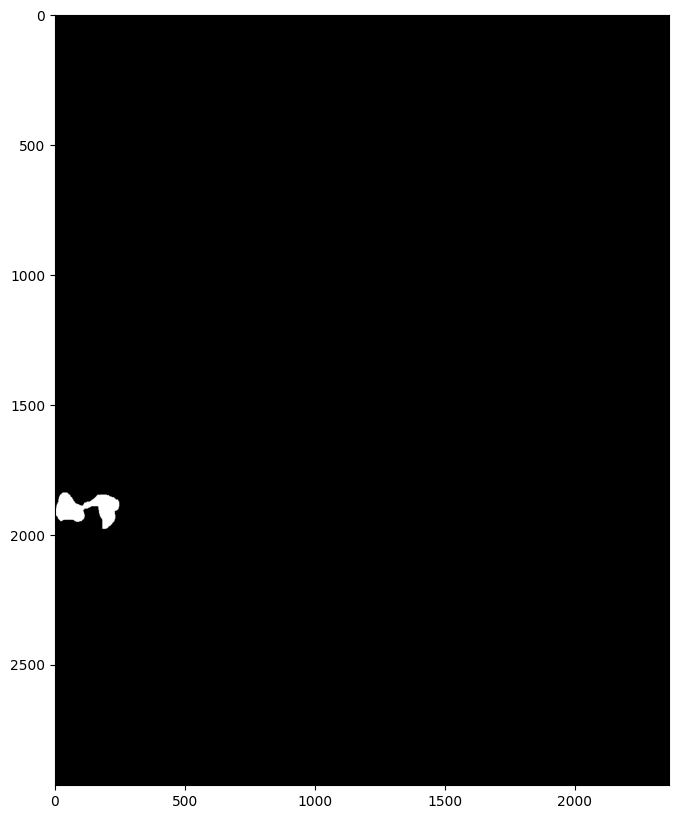

dtype: 8-bit unsigned integer
Get size: (2364, 2964)
Get direction: (1.0, 0.0, 0.0, 1.0)
Get spacing: (1.0, 1.0)
The origin: (0.0, 0.0)
Min: 0
Max: 1



In [33]:
binary_sitk = create_binary_mask(seg_sitk, im_sitk)
binary_array = sitk.GetArrayFromImage(binary_sitk)
plt.figure(figsize=(10,10))
plt.imshow(binary_array, cmap='gray')
plt.show()
stats_image(binary_sitk, show_histogram=False)
# save binary mask as nrrd
sitk.WriteImage(binary_sitk, f'{id_num}_G_L_binary.seg.nrrd')

expand_lu:[   1 1838]
expand_rd:[ 986 2117]


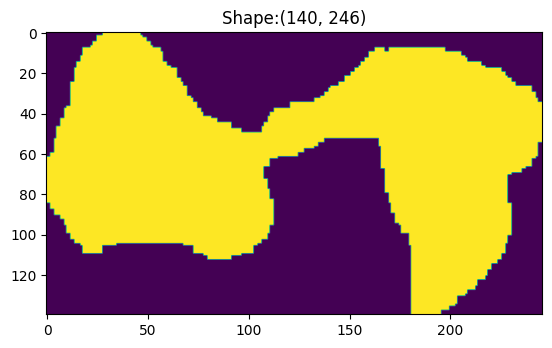

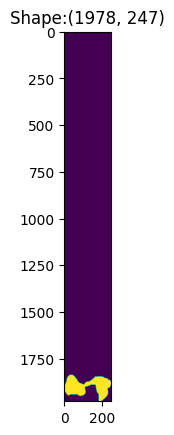

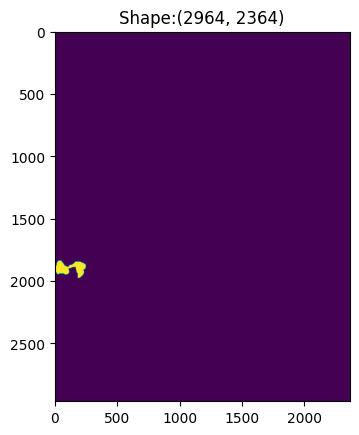

In [25]:
im_origin = (int(im_sitk.GetOrigin()[0]), int(im_sitk.GetOrigin()[1]))
seg_origin = (int(seg_sitk.GetOrigin()[0]), int(seg_sitk.GetOrigin()[1]))

seg_array = sitk.GetArrayFromImage(seg_sitk)
seg_array = seg_array[0] # remove z dimension

plt.figure()
plt.title(f'Shape:{seg_array.shape}')
plt.imshow(seg_array)

adding_lu = np.subtract(seg_origin, im_origin)
print(f'expand_lu:{adding_lu}')
# expand array to the left and up using the adding_lu array, careful with dimension order (sitk inversion)
seg_array = np.pad(seg_array, ((adding_lu[1],0), (adding_lu[0],0)), 'constant', constant_values=(0,0))
plt.figure()
plt.title(f'Shape:{seg_array.shape}')
plt.imshow(seg_array)

# expand to the right and down what is left using the image size
im_size = im_sitk.GetSize()
adding_rd = np.subtract(im_size[::-1], seg_array.shape) # invert image size tuple
print(f'expand_rd:{adding_rd}')
seg_array = np.pad(seg_array, ((0,adding_rd[0]), (0,adding_rd[1])), 'constant', constant_values=(0,0))
plt.figure()
plt.title(f'Shape:{seg_array.shape}')
plt.imshow(seg_array)

# Mask quality

Now that we have the binary mask, we cna compute information about the pixels inside of the masks, be sure that they are meaningful and no erouneous regiosn are being considered.

Text(0.5, 1.0, 'masked image histogram')

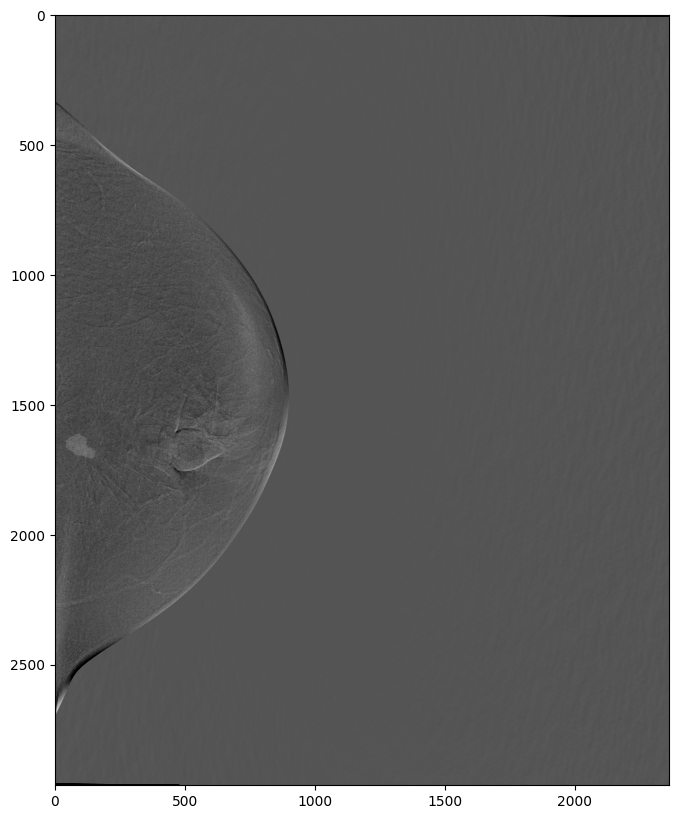

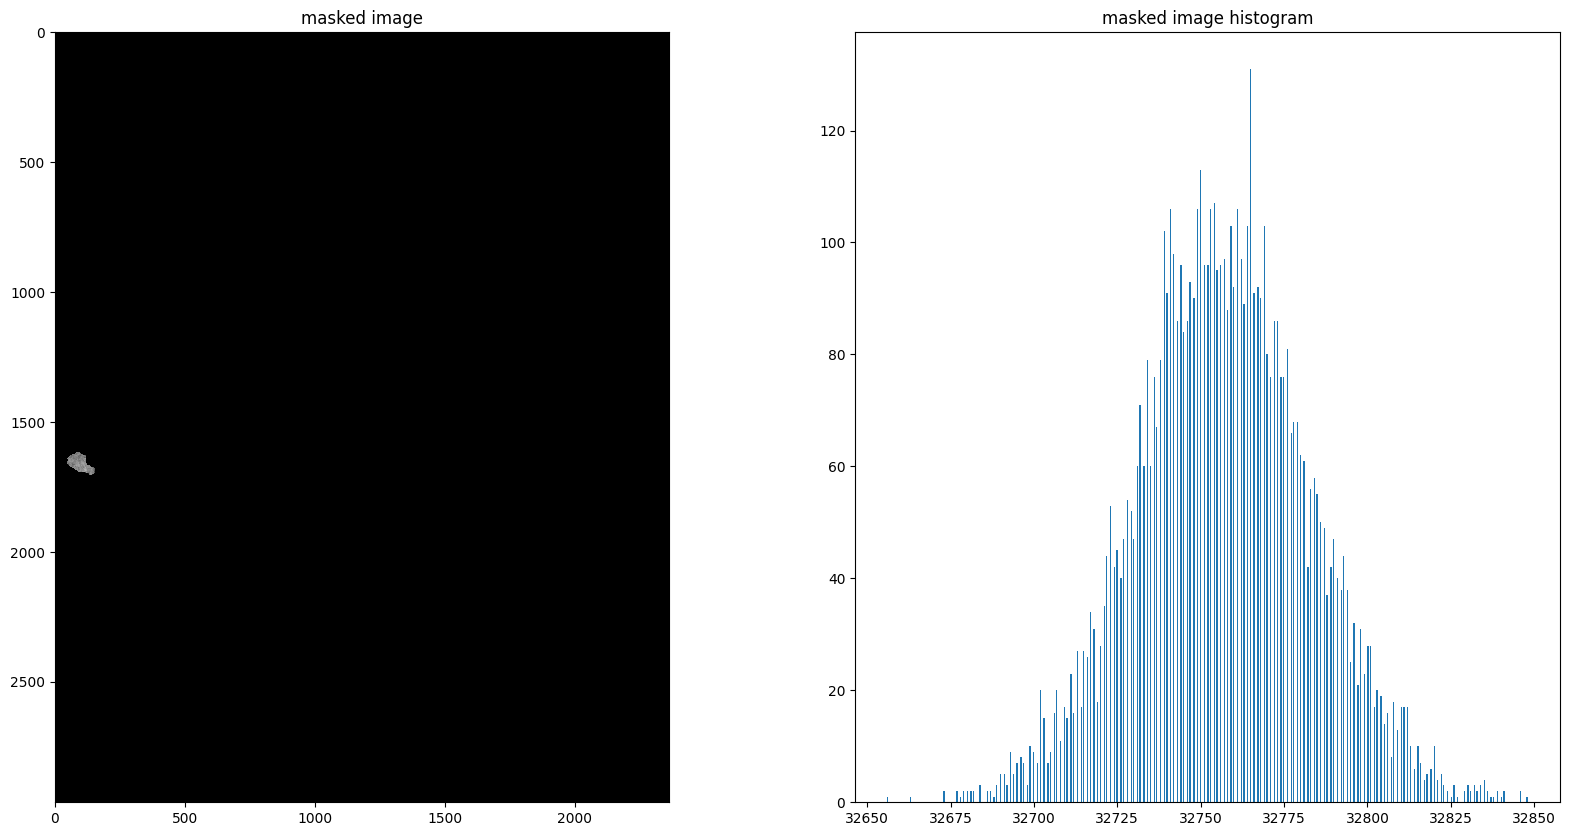

In [104]:
valid_patients = pd.read_csv(repo_path / 'data/valid_patients.csv', header=0, dtype=str)
image_dir = repo_path /'data/images/SET'
binary_dir = repo_path / 'data/binary_masks'

# eg
id_num = valid_patients.iloc[20].values[0]
rad = 'L'
time = '1'

mask_path = binary_dir / f'{rad}_{time}_seg/{id_num}_G_{rad}.seg.nrrd'
im_path = image_dir / f'Pat_{id_num}_SET_SMC_to_CMC_1min.tif'

# read images
im_sitk = sitk.ReadImage(str(im_path))
mask_sitk = sitk.ReadImage(str(mask_path))
im_array = sitk.GetArrayFromImage(im_sitk)
mask_array = sitk.GetArrayFromImage(mask_sitk)
# important region
masked_im = im_array*mask_array

plt.figure(figsize=(10,10))
# superimpose image and mask
plt.imshow(im_array, cmap='gray', vmin=32600, vmax=im_array.max()) 
plt.imshow(mask_array, cmap='gray', alpha=0.1)

fig, axs = plt.subplots(1,2, figsize=(20,10))
axs[0].imshow(masked_im, cmap='gray', vmin=np.unique(masked_im)[1])
axs[1].hist(masked_im.flatten(), bins=500, range=(np.unique(masked_im)[1], masked_im.max()))
# titles
axs[0].set_title('masked image')
axs[1].set_title('masked image histogram')

Some statistics can be performed to compute the similarity between the masks.
- mean value
- std value
- pixel range
- pixel count
- Dice score between pairs of masks

This comparision its at the patient-level.<br>

Interestingly enough, this comparison can also be performed using the radiomics deature. We can leave these values for the second phase of this mask quality control.

## Dice and HD computing
Pair-wise Dice is computed and then mean Dice can be obtained per mask.

In [125]:
def dice_computing(mask1:sitk.Image, mask2:sitk.Image):
    """computes the dice coefficient between the image and the mask

    Args:
        mask1 (sitk.Image): image
        mask2 (sitk.Image): mask

    Returns:
        float: dice coefficient
    """
    # get arrays
    mask1 = sitk.GetArrayFromImage(mask1)
    mask2 = sitk.GetArrayFromImage(mask2)
    # compute dice
    dice = 2*np.sum(mask1*mask2)/(np.sum(mask1)+np.sum(mask2))
    return dice

def hausdorff_distance(mask1:sitk.Image, mask2:sitk.Image):
    """compute HD between two masks

    Args:
        mask1 (sitk.Image): mask 1
        mask2 (sitk.Image): mask 2

    Returns:
        float: HD distance as float
    """
    hausdorff = sitk.HausdorffDistanceImageFilter()
    hausdorff.Execute(mask1, mask2)
    return hausdorff.GetHausdorffDistance()

Radiologist intervaliability

In [131]:
valid_patients = pd.read_csv(repo_path / 'data/valid_patients.csv', header=0, dtype=str)
image_dir = repo_path /'data/images/SET'
binary_dir = repo_path / 'data/binary_masks'

# df empty, no columns
df = pd.DataFrame()
# loop over patients
for id_num in valid_patients['pat_num']:
    for rad in ['L', 'M','V']:        
        mask1_path = binary_dir / f'{rad}_1_seg/{id_num}_G_{rad}.seg.nrrd'
        mask2_path = binary_dir / f'{rad}_2_seg/{id_num}_G_{rad}.seg.nrrd'

        # read masks
        mask1_sitk = sitk.ReadImage(str(mask1_path))
        mask2_sitk = sitk.ReadImage(str(mask2_path))
        # compute
        dice = dice_computing(mask1_sitk, mask2_sitk)
        hd = hausdorff_distance(mask1_sitk, mask2_sitk)
        # add to df
        df.loc[id_num, f'{rad}_dice'] = dice
        df.loc[id_num, f'{rad}_hd'] = hd
        

<Axes: >

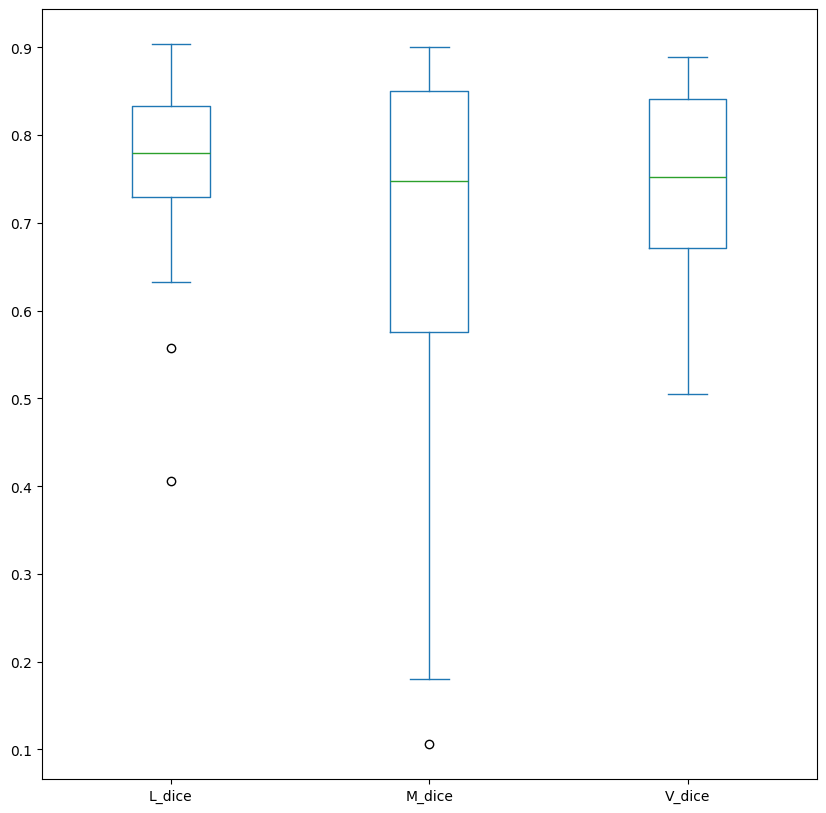

In [139]:
# select only dice columns
df_dice = df.filter(regex='dice')
df_dice.plot(kind='box', figsize=(10,10))